# Make Perturbed States

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig39


### Flo's original approach for perturbation
1) 
I used `/home/flop/switch/5thround/DHRs/make_DHR_states_4.ipynb` to generate states.  
outputs should be in `/home/flop/switch/5thround/DHRs/states` and in `/home/flop/switch/5thround/DHRs/states_no_clashcheck/`  
if you look at the notebook you'll see that there is a clash check option.  
For the first couple of rounds discarded everything that failed the clash check, for the last round I ignored the clash check  
mainly because in the beginning I used fixed bb as long as possible, later i switched to flex bb  
and found that flexxbb design can actually produce very nice interfaces from starting points that clash heavily

### I will follow Flo's docking procedure nearly exactly
I will use the serialization build of PyRosetta to enable recording user defined info about the docks.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

### Make functions for docking

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *


@requires_init
def load_from_silents(silent=None, **kwargs) -> Generator[str, PackedPose, None]:
    """
    Generate PackedPose objects from a binary silent file.
    Must initialize Rosetta with the "-in:file:silent_struct_type binary" flag.
    """
    import pyrosetta.distributed.io as io

    if silent == None:
        silent = kwargs["-in:file:silent"]
    pposes = io.poses_from_silent(silent)
    for ppose in pposes:
        yield ppose


def make_states(pose: PackedPose, **kwargs) -> list:
    """
    Method to make a list of alternative states from the input PackedPose.
    This is done by splitting, superimposing and rotating one full heptad up and one
    full heptad down for helices before and after the break, defined by the
    pre_break_helix kwarg.
    """
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    from pyrosetta.distributed.packed_pose.core import PackedPose
    import pyrosetta.distributed.io as io

    def range_CA_align(pose_a, pose_b, start_a, end_a, start_b, end_b):
        """
        Align poses by superimposition of CA given two ranges of indices.
        (pose 1 mobile)
        Modified from apmoyer.
        """
        import pyrosetta

        pose_a_residue_selection = range(start_a, end_a)
        pose_b_residue_selection = range(start_b, end_b)

        assert len(pose_a_residue_selection) == len(pose_b_residue_selection)

        pose_a_coordinates = (
            pyrosetta.rosetta.utility.vector1_numeric_xyzVector_double_t()
        )
        pose_b_coordinates = (
            pyrosetta.rosetta.utility.vector1_numeric_xyzVector_double_t()
        )

        for pose_a_residue_index, pose_b_residue_index in zip(
            pose_a_residue_selection, pose_b_residue_selection
        ):
            pose_a_coordinates.append(pose_a.residues[pose_a_residue_index].xyz("CA"))
            pose_b_coordinates.append(pose_b.residues[pose_b_residue_index].xyz("CA"))

        rotation_matrix = pyrosetta.rosetta.numeric.xyzMatrix_double_t()
        pose_a_center = pyrosetta.rosetta.numeric.xyzVector_double_t()
        pose_b_center = pyrosetta.rosetta.numeric.xyzVector_double_t()

        pyrosetta.rosetta.protocols.toolbox.superposition_transform(
            pose_a_coordinates,
            pose_b_coordinates,
            rotation_matrix,
            pose_a_center,
            pose_b_center,
        )

        pyrosetta.rosetta.protocols.toolbox.apply_superposition_transform(
            pose_a, rotation_matrix, pose_a_center, pose_b_center
        )
        return

    def clash_check(pose: Pose) -> float:
        """
        Mutate all residues to glycine then check the score of the mutated pose.
        Print the score and return it.
        """
        import pyrosetta

        # initialize empty sfxn
        sfxn = pyrosetta.rosetta.core.scoring.ScoreFunction()
        sfxn.set_weight(pyrosetta.rosetta.core.scoring.fa_rep, 1)
        # make the pose into a backbone without sidechains
        all_gly = pose.clone()
        true_sel = pyrosetta.rosetta.core.select.residue_selector.TrueResidueSelector()
        true_x = true_sel.apply(all_gly)
        # settle the pose
        pyrosetta.rosetta.protocols.toolbox.pose_manipulation.repack_these_residues(
            true_x, all_gly, sfxn, False, "G"
        )
        score = sfxn(all_gly)
        return score

    def helix_dict_maker(pose: Pose) -> dict:
        """
        Make a dictionary of which residues belong to which helices then return it.
        """
        import pyrosetta

        ss = pyrosetta.rosetta.core.scoring.dssp.Dssp(pose)
        helix_dict = {}
        n = 1
        for i in range(1, len(pose.sequence())):
            if (ss.get_dssp_secstruct(i) == "H") & (
                ss.get_dssp_secstruct(i - 1) != "H"
            ):
                helix_dict[n] = [i]
            if (ss.get_dssp_secstruct(i) == "H") & (
                ss.get_dssp_secstruct(i + 1) != "H"
            ):
                helix_dict[n].append(i)
                n += 1
        return helix_dict

    def get_helix_endpoints(pose: Pose, n_terminal: bool) -> dict:
        """
        Make a dictionary of the start (n_terminal=True) or end residue indices of each helix
        """
        helix_dict = helix_dict_maker(pose)
        helix_endpoints = {}
        if n_terminal:
            index = 0  # helix start residue
        else:
            index = -1  # helix end residue
        for helix, residue_list in helix_dict.items():
            helix_endpoints[helix] = residue_list[index]
        return helix_endpoints

    def combine_two_poses(pose_a: Pose, pose_b: Pose, end_a: int, start_b: int) -> Pose:
        """
        Make a new pose, containing pose_a up to end_a, then pose_b starting from start_b
        Assumes pose_a has only one chain.
        """
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        assert len(pose_a.sequence()) == len(pose_b.sequence())
        length = len(pose_a.sequence())
        newpose = Pose()
        for i in range(1, end_a + 1):
            newpose.append_residue_by_bond(pose_a.residue(i))
        newpose.append_residue_by_jump(
            pose_b.residue(start_b), newpose.chain_end(1), "CA", "CA", 1
        )
        for i in range(start_b + 1, length + 1):
            newpose.append_residue_by_bond(pose_b.residue(i))
        return newpose

    def shift_chB_by_i(
        pose: Pose,
        i: int,
        starts: dict,
        ends: dict,
        pivot_helix: int,
        pre_break_helix: int,
    ) -> Pose:
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        pose = pose.clone()
        copypose = pose.clone()
        start = starts[pivot_helix]
        end = ends[pivot_helix]
        starts_tup = tuple(start for start in 4 * [start])
        ends_tup = tuple(end for end in 4 * [end])
        # make sure there's enough helix to align against going forwards
        if (i >= 0) and ((start + 10 + i) <= end):
            offsets = 3, 10, 3 + i, 10 + i
            start_a, end_a, start_b, end_b = tuple(map(sum, zip(starts_tup, offsets)))
        # make sure there's enough helix to align against going backwards
        elif (i <= 0) and ((end - 10 + i) >= start):
            offsets = -10, -3, -10 + i, -3 + i
            start_a, end_a, start_b, end_b = tuple(map(sum, zip(ends_tup, offsets)))
        else:
            raise RuntimeError("not enough overlap to align")
        range_CA_align(copypose, pose, start_a, end_a, start_b, end_b)
        end_pose_a, start_pose_b = ends[pre_break_helix], starts[pre_break_helix + 1]
        shifted_pose = combine_two_poses(pose, copypose, end_pose_a, start_pose_b)
        return shifted_pose

    pose = io.to_pose(pose)
    if not "name" in kwargs:
        name = pose.pdb_info().name()
    else:
        name = kwargs["name"]
    try:
        pre_break_helix = kwargs["pre_break_helix"]
    except KeyError:
        raise RuntimeError("need to supply pre_break_helix")
    parent_length = len(pose.residues)
    starts = get_helix_endpoints(pose, n_terminal=True)
    ends = get_helix_endpoints(pose, n_terminal=False)
    states = []
    nstruct = 0
    post_break_helix = pre_break_helix + 1
    # scan 1 heptad forwards and backwards
    for i in range(-7, 8):
        # first do the pre break side, then do the post break side
        for pivot_helix in [pre_break_helix, post_break_helix]:
            try:
                shift = shift_chB_by_i(
                    pose, i, starts, ends, pivot_helix, pre_break_helix
                )
                nstruct += 1
                pdb_info = pyrosetta.rosetta.core.pose.PDBInfo(shift)
                shift.pdb_info(pdb_info)
                shift.pdb_info().name(name + "_{}".format(nstruct))
                bb_clash = clash_check(shift)
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    shift, "bb_clash", float(bb_clash)
                )
                pyrosetta.rosetta.core.pose.setPoseExtraScore(shift, "parent", name)
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    shift, "parent_length", str(parent_length)
                )
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    shift, "pivot_helix", str(pivot_helix)
                )
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    shift, "pre_break_helix", str(pre_break_helix)
                )
                pyrosetta.rosetta.core.pose.setPoseExtraScore(shift, "shift", str(i))
                ppose = io.to_packed(shift)
                states.append(ppose)
            except:  # for cases where there isn't enough to align against
                continue
    return states

### Setup dask, set command line options, make tasks and submit to client

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run one of the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}.ipd"
)

silents = glob(os.path.join(os.getcwd(), "00_silents/*.silent"))

print("silents: {}".format(",".join(silents)))

output_path = os.path.join(os.getcwd(), "01_make_states")


def create_tasks(options):
    for silent in silents:
        tasks = {
            "options": "",
            "extra_options": options,
            "set_logging_handler": "interactive",
            "-in:file:silent": os.path.join(os.getcwd(), silent),
        }
        # use kwargs to match the right pre_break_helix with the right scaffold type
        if "thr" in silent:
            tasks["pre_break_helix"] = 6
        else:
            tasks["pre_break_helix"] = 4
        yield tasks


options = {
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
}


if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="short",
        walltime="1:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-100 workers,
        cluster.adapt(
            minimum=1,
            maximum=100,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            logging.basicConfig(level=logging.INFO)
            PyRosettaCluster(
                tasks=create_tasks(options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[load_from_silents, make_states])

run one of the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig147
ssh -L 8000:localhost:8787 pleung@dig147.ipd
silents: /mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/thrs.silent,/mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/dhrsgoodnocys.silent,/mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/th_dhrs.silent,/mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/harley.silent,/mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/harley_thrs.silent,/mnt/home/pleung/projects/bistable_bundle/r4/hinges/00_silents/dhrs_nocys.silent
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p short
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 1:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.13

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Look at scores
Hacky function to load JSON-like data

In [2]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "01_make_states")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,bb_clash,parent,parent_length,pivot_helix,pre_break_helix,shift
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/01_make_states/decoys/0000/2021.04.23.14.19.39.341468_86a50ef83af640f89418a5c91b6757f9.pdb.bz2,18028.406250,THR9,316,6,6,-7
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/01_make_states/decoys/0000/2021.04.23.14.19.39.341468_c370f84bd5ba490a8e9902cb9881c416.pdb.bz2,104.091003,THR9,316,7,6,-7
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/01_make_states/decoys/0000/2021.04.23.14.19.39.341468_61716fd6386e47fbb4cd59c739833e8c.pdb.bz2,72016.148438,THR9,316,6,6,-6
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/01_make_states/decoys/0000/2021.04.23.14.19.39.341468_e8103dc6d9ab4b88b370f2b102e20855.pdb.bz2,730.979553,THR9,316,7,6,-6
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/01_make_states/decoys/0000/2021.04.23.14.19.39.341468_f991a6120a6d482aa6f5915ccef81d6f.pdb.bz2,112.612465,THR9,316,6,6,-5


In [3]:
len(scores_df)

1872

### Analyze some scoreterms
Filtering only on `bb_clash` for now

In [4]:
scores_df.columns

Index(['bb_clash', 'parent', 'parent_length', 'pivot_helix', 'pre_break_helix',
       'shift'],
      dtype='object')

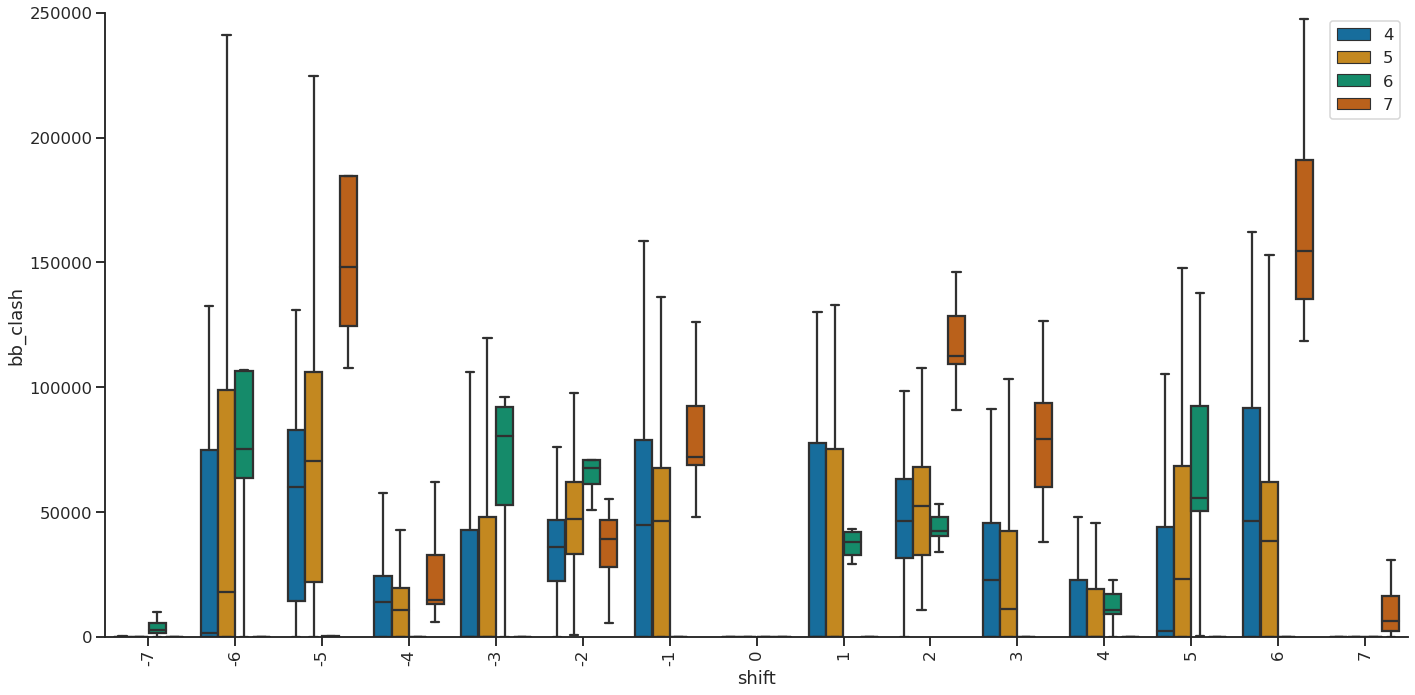

In [8]:
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

order = [int(x) for x in set(scores_df["shift"].values)]
order.sort()
order = [str(x) for x in order]

fig = plt.figure(figsize=(20, 10), tight_layout=True)
pivot_order = ["4", "5", "6", "7"]
ax = sns.boxplot(
    x="shift",
    y="bb_clash",
    data=scores_df,
    order=order,
    showfliers=False,
    hue="pivot_helix",
    hue_order=pivot_order,
)
ax.legend(loc="upper right")
ax.set_ylim(0, 250000)
sns.despine()
plt.setp(ax.get_legend().get_title(), fontsize="24")
plt.xticks(rotation=90)
plt.savefig("figs/01_shift_vs_clash_groupby_pivot.png")

In [9]:
sorted_parents = sorted(list(set(scores_df.parent.values)))
thrs = [x for x in sorted_parents if "THR" in x]
dhrs_nocys = [x for x in sorted_parents if "nocys" in x]
th_dhrs = [x for x in sorted_parents if "TH_DHR" in x]
kh = [x for x in sorted_parents if "KH_" in x]
dhrs = [
    x
    for x in sorted_parents
    if ("THR" not in x and "nocys" not in x and "TH_DHR" not in x and "KH_" not in x)
]

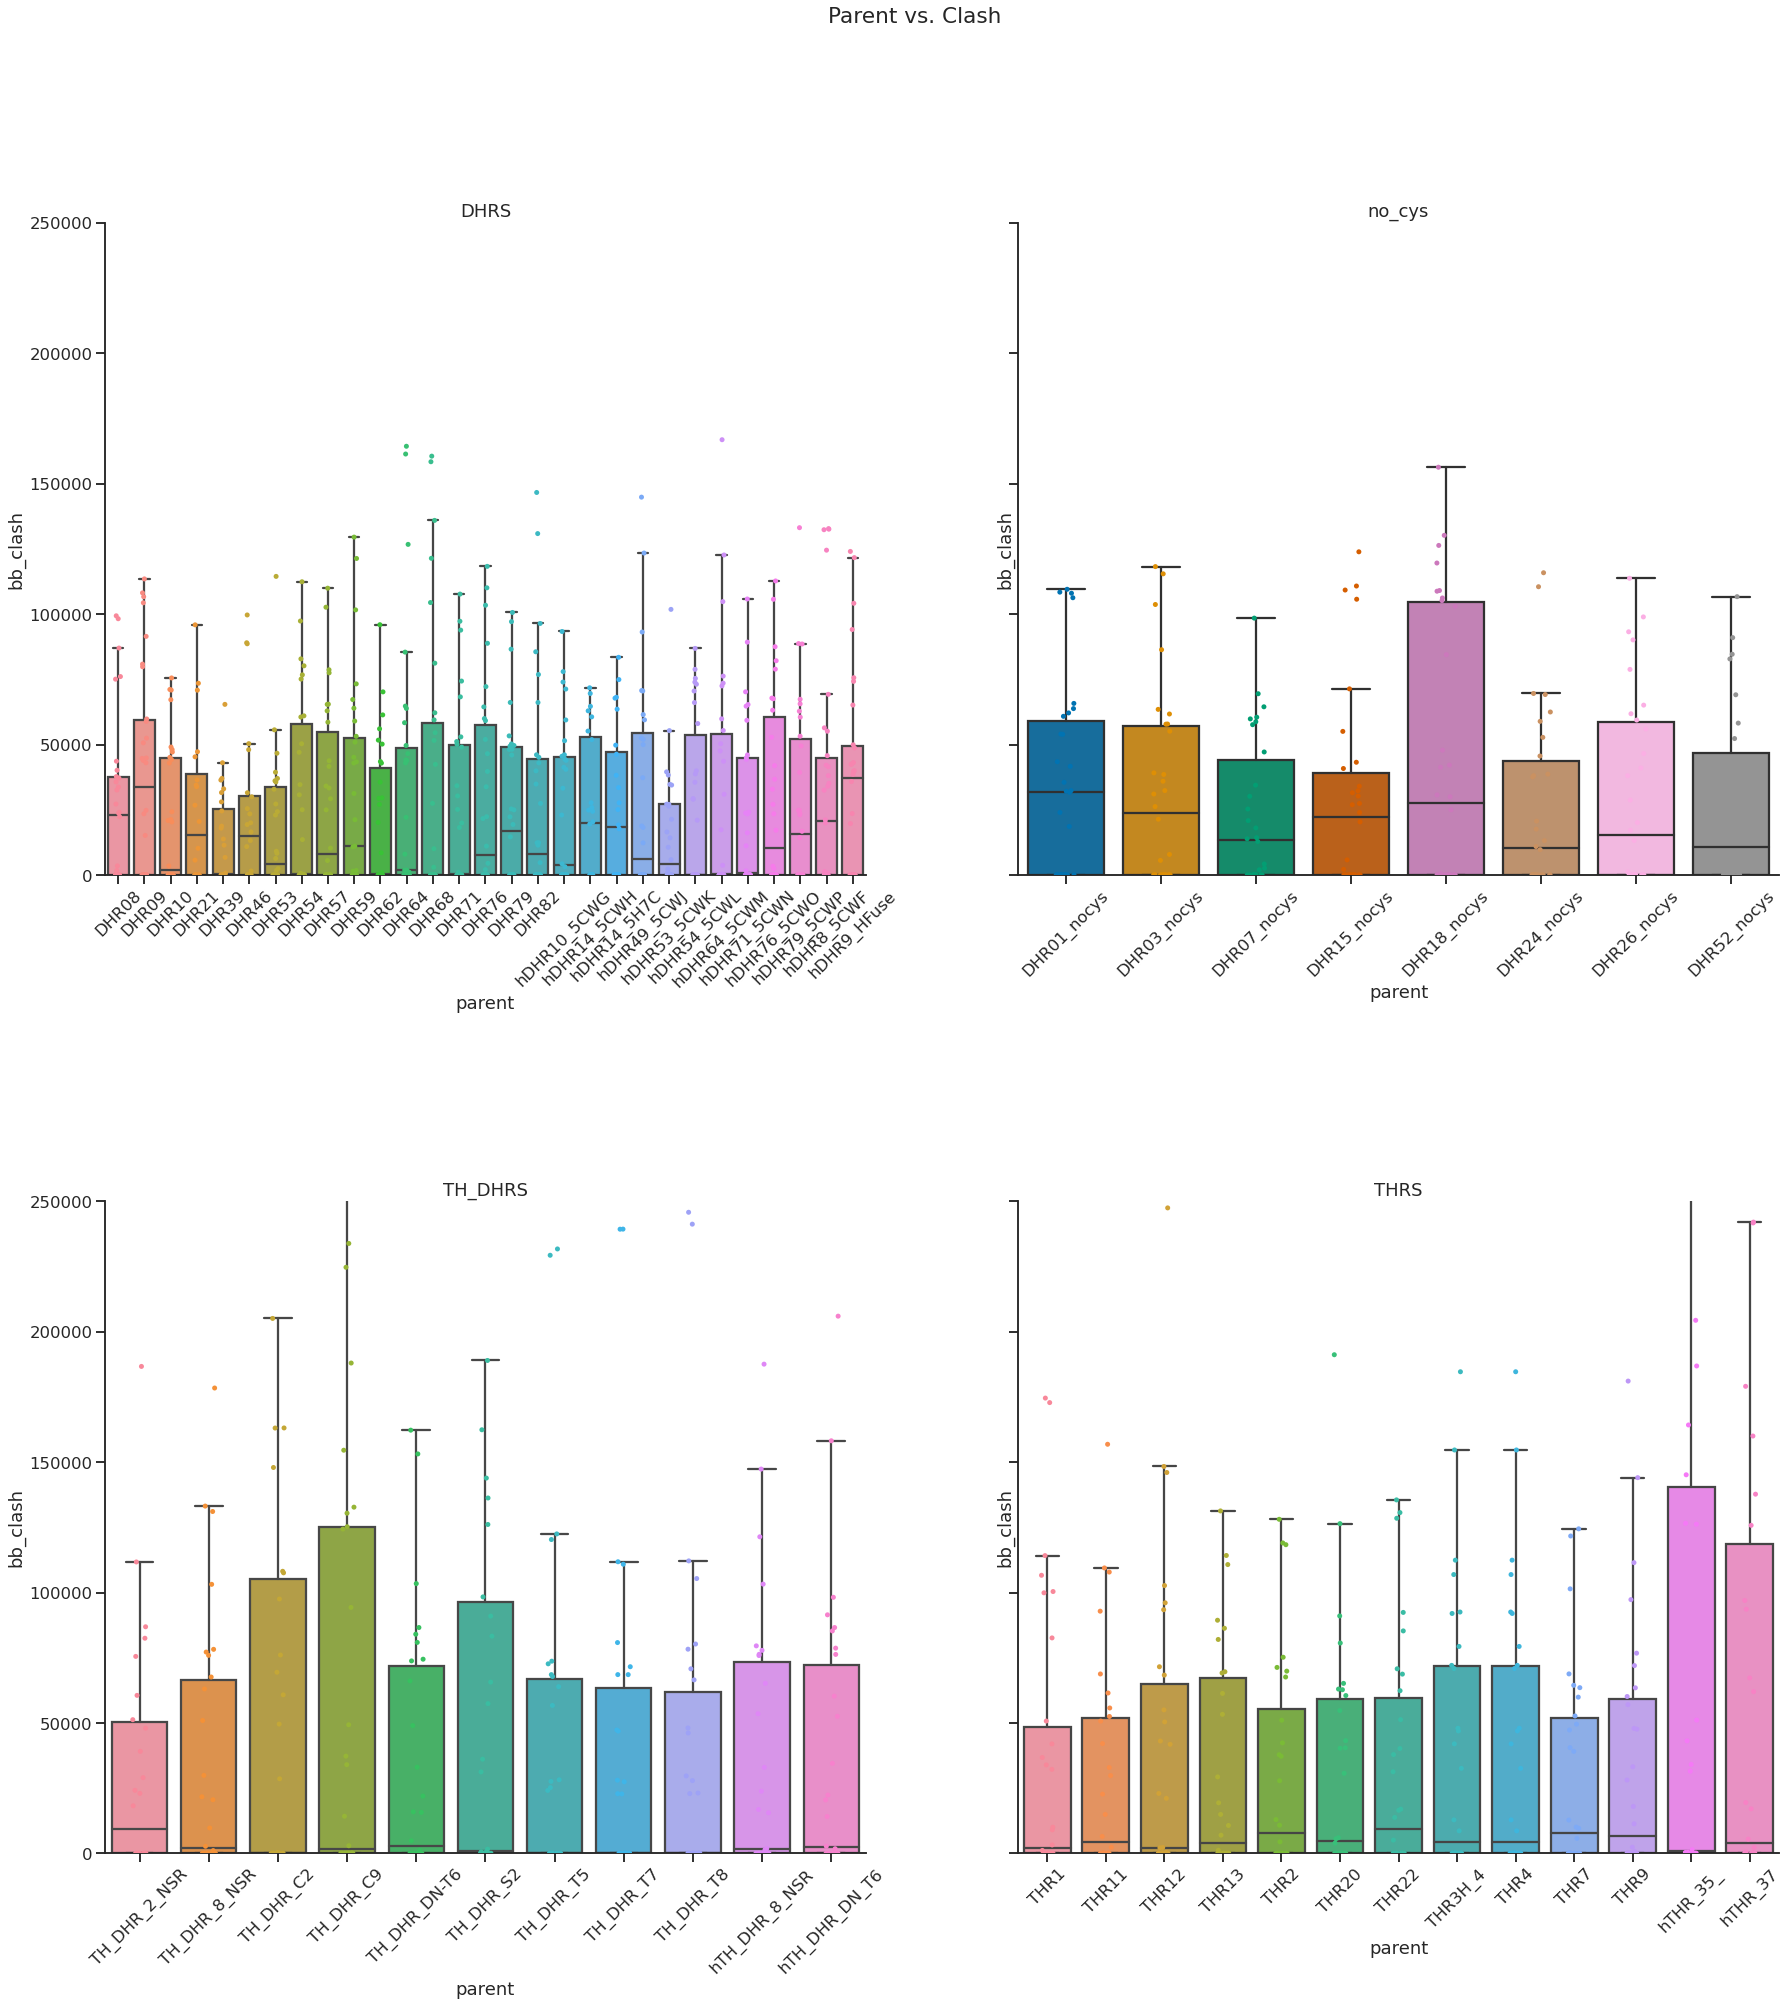

In [10]:
data_orders = [dhrs, dhrs_nocys, th_dhrs, thrs]
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(30, 30))
fig.suptitle("Parent vs. Clash")
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)
for order, ax in zip(data_orders, axs.flatten()):
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_ylim(0, 250000)
    sns.boxplot(
        ax=ax,
        x="parent",
        y="bb_clash",
        data=scores_df,
        order=order,
        showfliers=False,
    )
    sns.stripplot(
        ax=ax,
        x="parent",
        y="bb_clash",
        data=scores_df,
        order=order,
    )
    sns.despine()
axs[0][0].set_title("DHRS")
axs[0][1].set_title("no_cys")
axs[1][0].set_title("TH_DHRS")
axs[1][1].set_title("THRS")
plt.savefig("figs/01_all_parents_vs_clash.png")

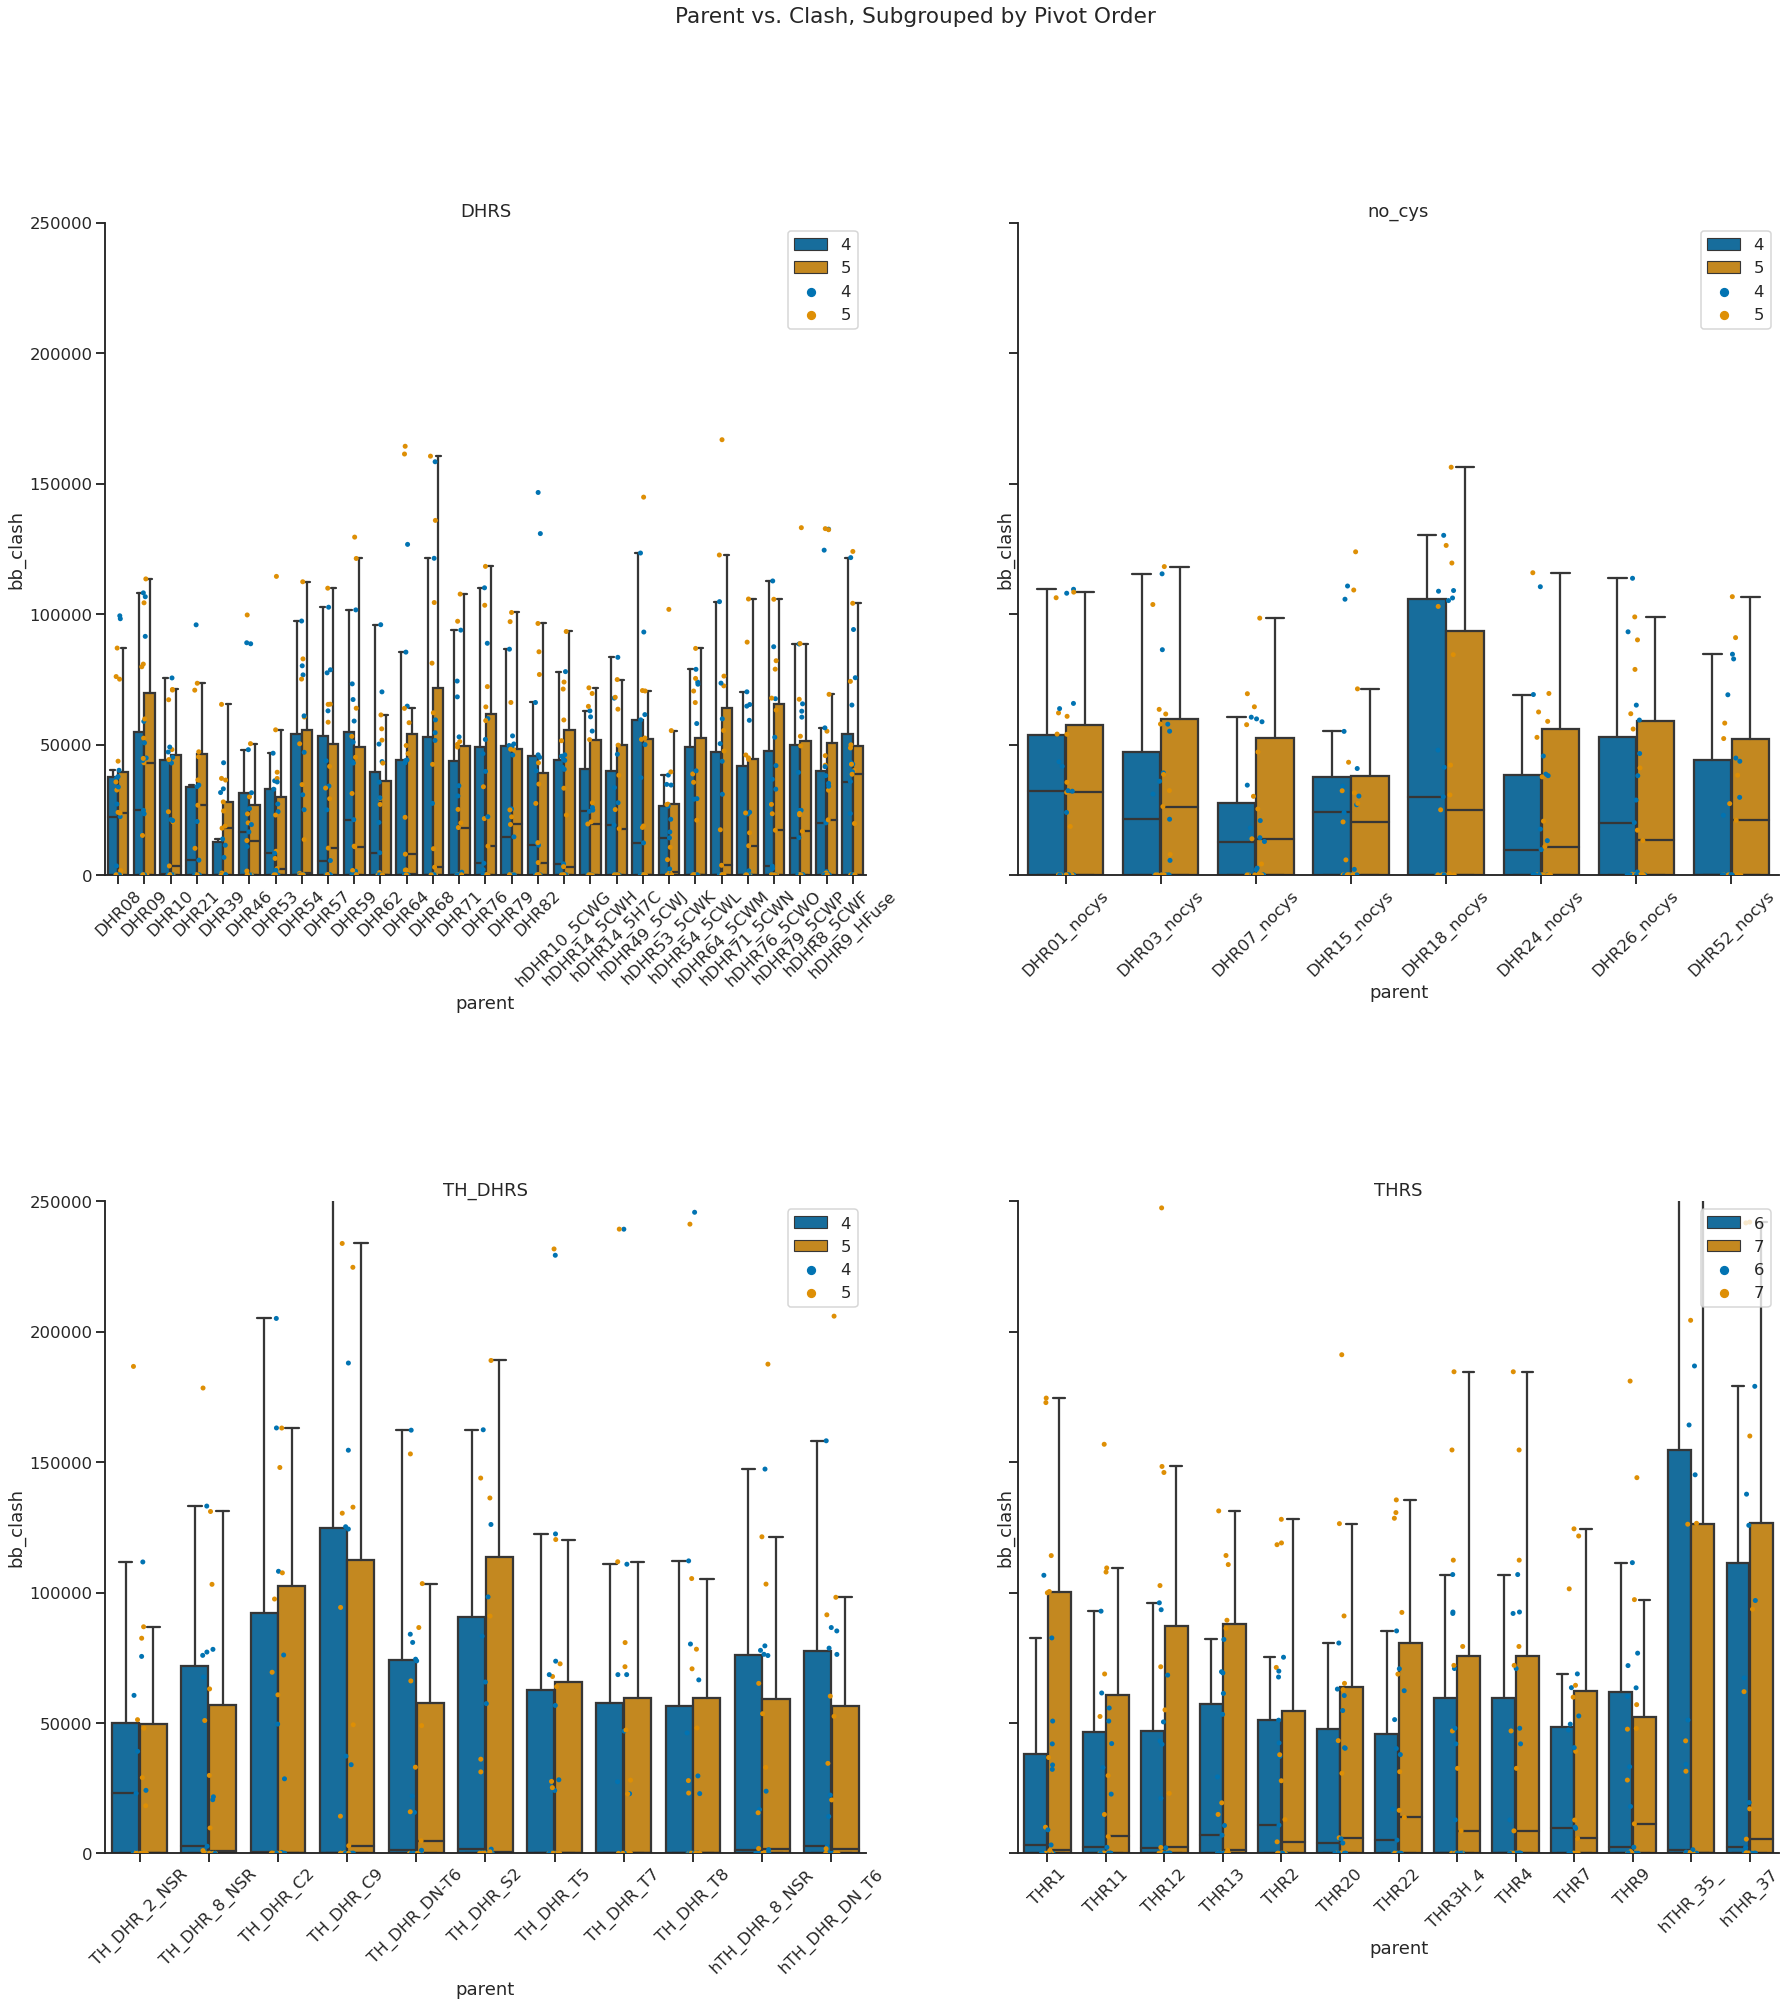

In [11]:
data_orders = [dhrs, dhrs_nocys, th_dhrs, thrs]
pivot_orders = [["4", "5"], ["4", "5"], ["4", "5"], ["6", "7"]]
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(30, 30))
fig.suptitle("Parent vs. Clash, Subgrouped by Pivot Order")
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)
for order, ax, pivot_order in zip(data_orders, axs.flatten(), pivot_orders):
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_ylim(0, 250000)
    sns.boxplot(
        ax=ax,
        x="parent",
        y="bb_clash",
        data=scores_df,
        order=order,
        showfliers=False,
        hue="pivot_helix",
        hue_order=pivot_order,
    )
    sns.stripplot(
        ax=ax,
        x="parent",
        y="bb_clash",
        data=scores_df,
        order=order,
        hue="pivot_helix",
        hue_order=pivot_order,
    )
    sns.despine()
    ax.legend(loc="upper right")
axs[0][0].set_title("DHRS")
axs[0][1].set_title("no_cys")
axs[1][0].set_title("TH_DHRS")
axs[1][1].set_title("THRS")
plt.savefig("figs/01_all_parents_vs_clash_subgrouped_pivots.png")

### Add scaffold type

In [12]:
scaffold = []
for value in scores_df.parent.values:
    if "TH_DHR" in value:
        name = "TH_DHR"
    elif "KH_" in value:
        name = "KH_DHR"
    elif "THR" in value:
        name = "THR"
    elif "DHR" in value:
        name = "DHR"
    else:
        print("unexpected name encountered")
    scaffold.append(name)
scores_df["scaffold"] = scaffold
scores_df.groupby(["scaffold"]).mean()

,bb_clash
scaffold,
DHR,28134.548187
KH_DHR,23103.800808
THR,40424.612300
TH_DHR,44972.187717


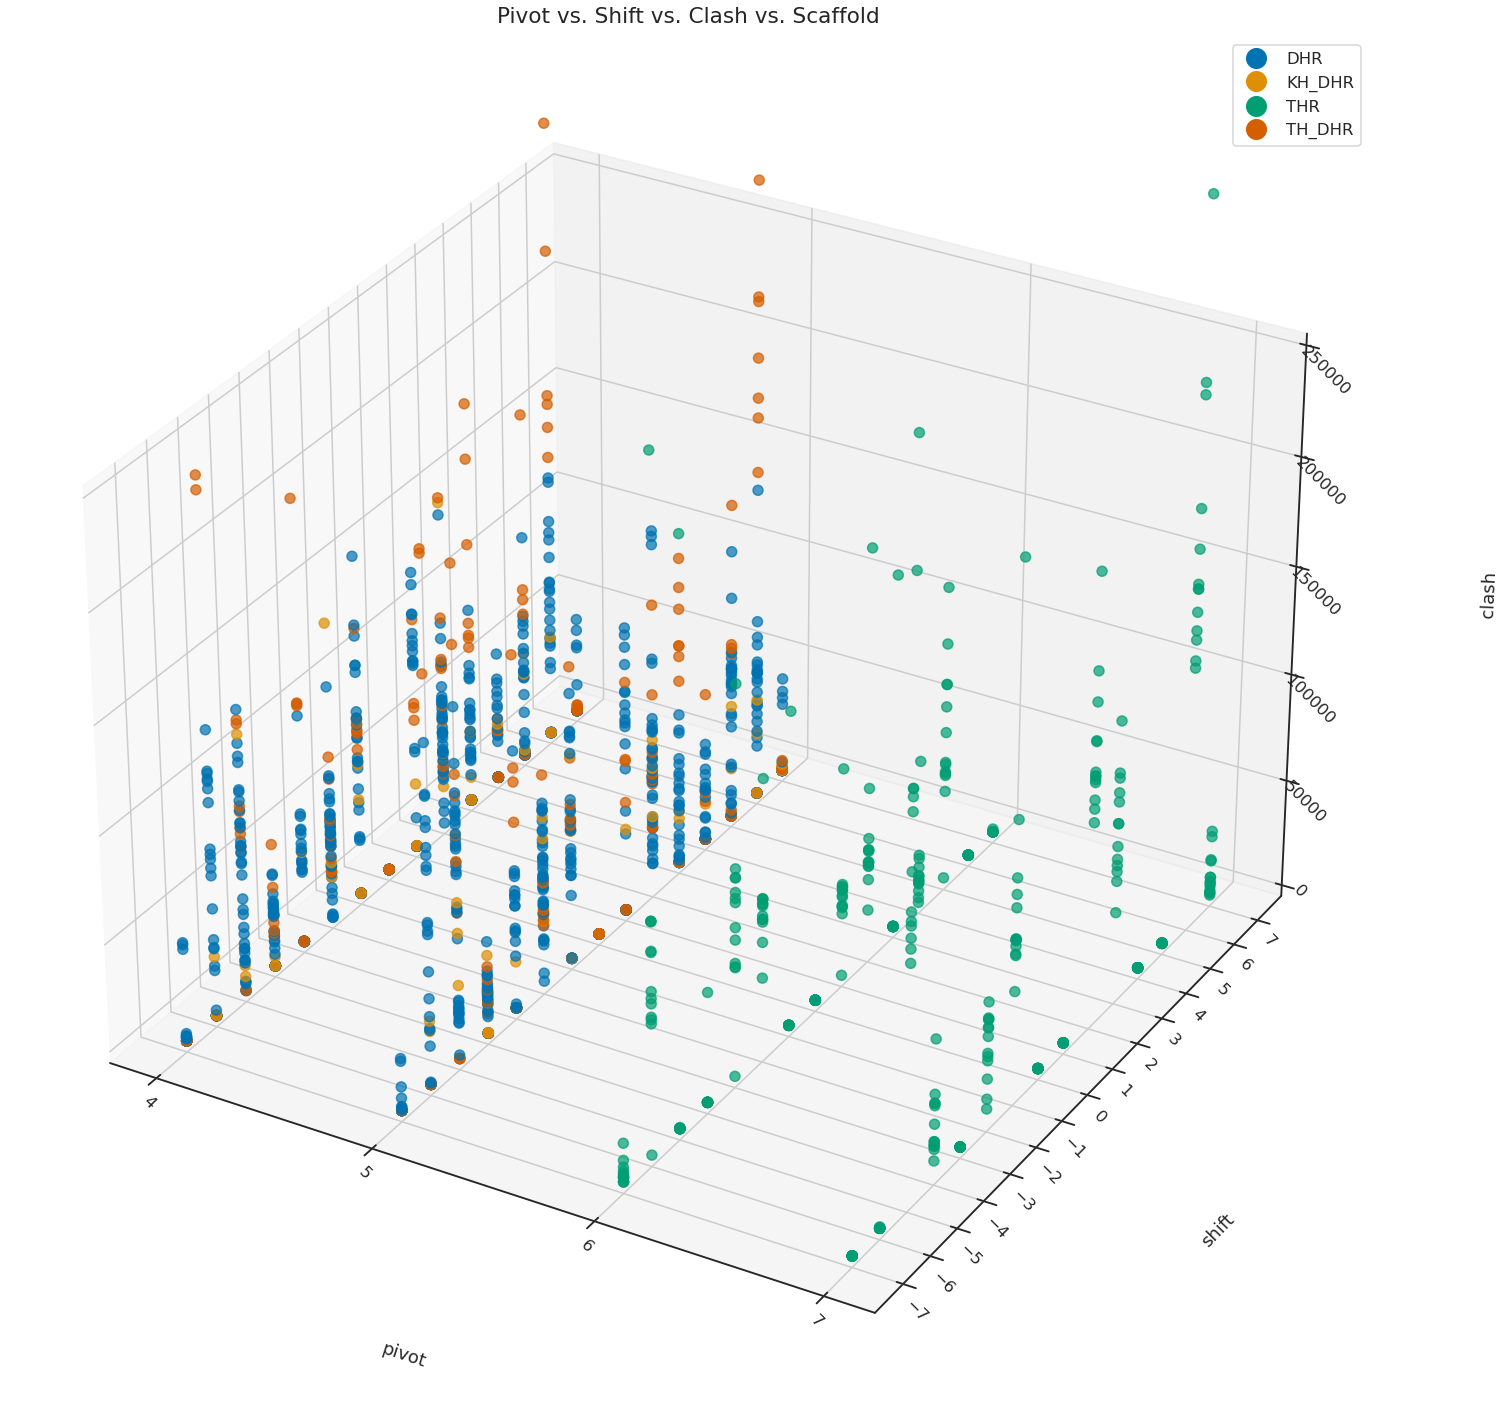

In [13]:
palette = list(sns.color_palette("colorblind", 256).as_hex())
palette = palette[:4]
scaffold_classes = sorted(list(set(scores_df.scaffold.values)))
color_dict = dict(zip(scaffold_classes, palette))

x = [int(x) for x in scores_df["pivot_helix"]]
y = [int(x) for x in scores_df["shift"]]
z = list(scores_df["bb_clash"])
c = [color_dict[x] for x in list(scores_df["scaffold"])]

fig = plt.figure(figsize=(20, 20), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, c=c, s=100, alpha=0.7)
ax.set_xlabel("pivot", labelpad=100)
ax.set_ylabel("shift", labelpad=100)
ax.set_zlabel("clash", labelpad=100)
ax.set_zlim(0, 250000)
ax.tick_params(axis="both", labelrotation=-45)
ax.set_xticks([4, 5, 6, 7])
ax.set_yticks(range(-7, 8))
markers = [
    plt.Line2D([0, 0], [0, 0], color=color, marker="o", markersize=20, linestyle="")
    for color in color_dict.values()
]
plt.legend(markers, color_dict.keys(), numpoints=1)
fig.suptitle("Pivot vs. Shift vs. Clash vs. Scaffold")
plt.savefig("figs/01_pivot_vs_shift_vs_clash_subgrouped_scaffolds.png")

### Observations
1. THRs have more variability in clash but higher overall clash, and it varies a lot more as a function of the shift  
2. DHRs vary more between parent, as would be expected for their greater backbone diversity
3. TH_DHRs are similar in metrics to THRs
3. KH_DHRs are similar in metrics to DHRs


### Get decoys that pass a bb_clash cutoff, determine the best cutoff
For now, we just need to get rid of stuff with very bad clashes

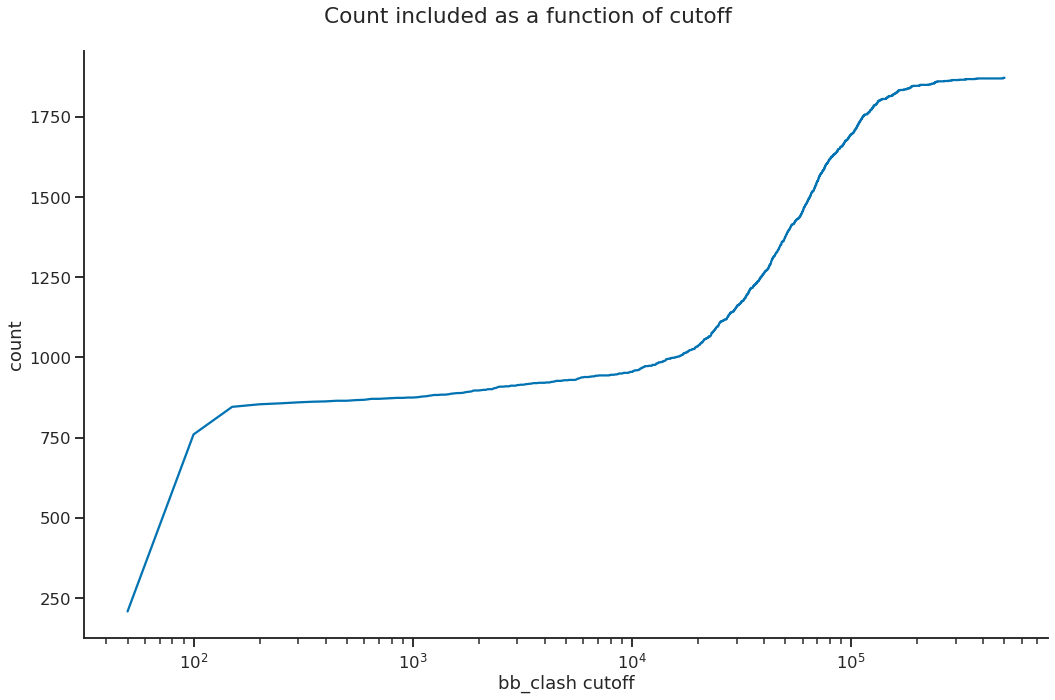

In [14]:
cutoffs, num = [], []
fig = plt.figure(figsize=(15, 10), tight_layout=True)

for cutoff in range(50, 500000, 50):
    filtered = scores_df[scores_df["bb_clash"] < cutoff]
    cutoffs.append(cutoff), num.append(len(filtered))

ax = sns.lineplot(x=cutoffs, y=num)
sns.despine()
ax.set_xscale("log")
_ = plt.xticks([100, 1000, 10000, 100000])
plt.xlabel("bb_clash cutoff")
plt.ylabel("count")
plt.suptitle("Count included as a function of cutoff")
plt.savefig("figs/01_cutoff_vs_count.png")

### As before, a flat cutoff of around 20000 should be fine 
Time to filter and check for class imbalances

In [15]:
selected = scores_df[scores_df["bb_clash"] < 20000]
print(len(selected), "selected structures")

1036 selected structures


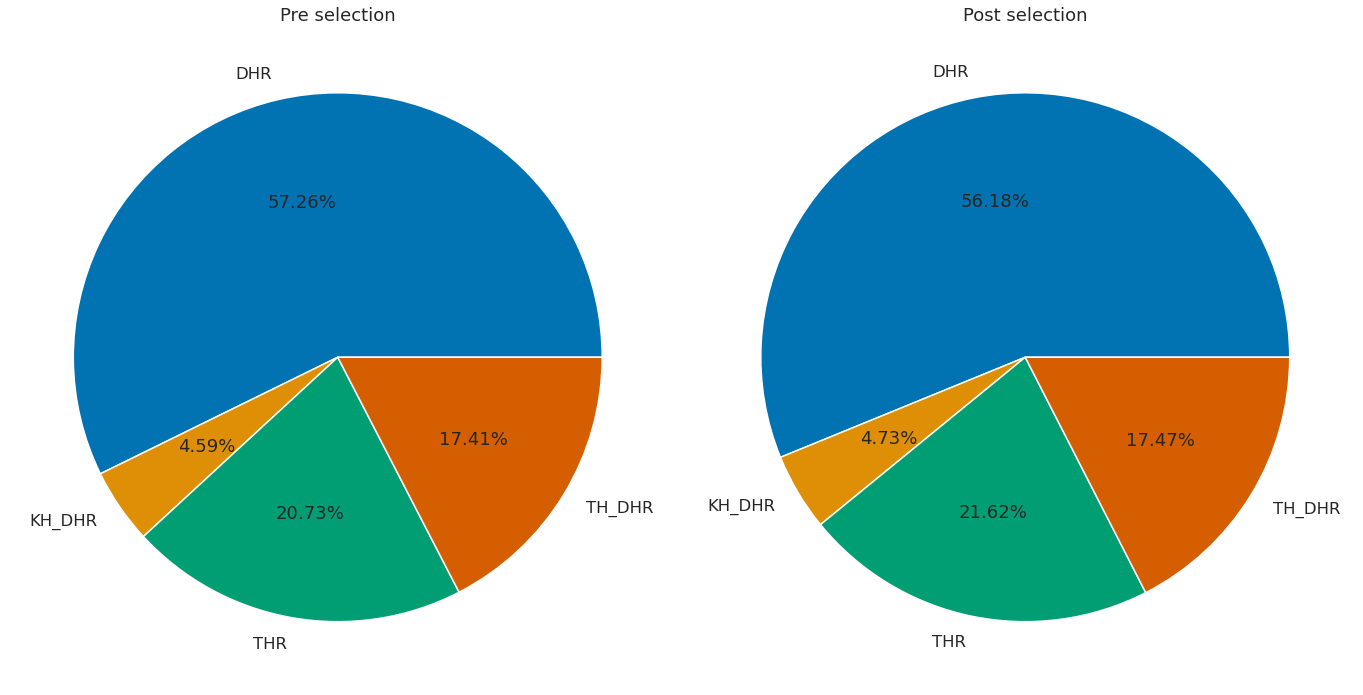

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
selected.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax1.set_title("Pre selection")
ax2.set_title("Post selection")
ax1.set_ylabel("")
ax2.set_ylabel("")
plt.tight_layout()
plt.savefig("figs/01_pre_post_selection.png")

### Saving list of states and reference states
Parent reference states would have a `shift` of 0 and a `pivot_helix` of 4 or 6

In [16]:
out_path = os.path.join(os.getcwd(), "01_make_states")
with open(os.path.join(out_path, "selected_states.list"), "w+") as f:
    for decoy in selected.index:
        print(decoy, file=f)

ref = scores_df.query("shift == '0' & (pivot_helix == '4' | pivot_helix == '6')")

with open(os.path.join(out_path, "reference_states.list"), "w+") as f:
    for decoy in ref.index:
        print(decoy, file=f)

### Unused blocks

In [4]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-in:file:silent_struct_type binary
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t_ppose = next(load_from_silents(
    None,
    **{
        "-in:file:silent": os.path.join(os.getcwd(), "plotting.silent"),
    }
))
tpposes = make_states(t_ppose, **{"pre_break_helix": 4})

CPU times: user 6.77 s, sys: 358 ms, total: 7.12 s
Wall time: 8.73 s


In [9]:
for i, ppose in enumerate(tpposes):
    ppose.pose.dump_pdb(
        f"DHR_82_p_{ppose.pose.scores['pivot_helix']}_s_{ppose.pose.scores['shift']}.pdb"
    )